In [35]:
# import all necessary libraries. 

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as keras
from sklearn.datasets import load_sample_images
import matplotlib as mpl
from functools import partial
import tensorflow_datasets as tfds

In [2]:
# Load two sample images, scale their pixels from 0 to 1, and center crop to 70 by 120. 

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

In [3]:
images.shape

TensorShape([2, 70, 120, 3])

In [4]:
tf.random.set_seed(42)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)
print(fmaps.shape)

(2, 64, 114, 32)


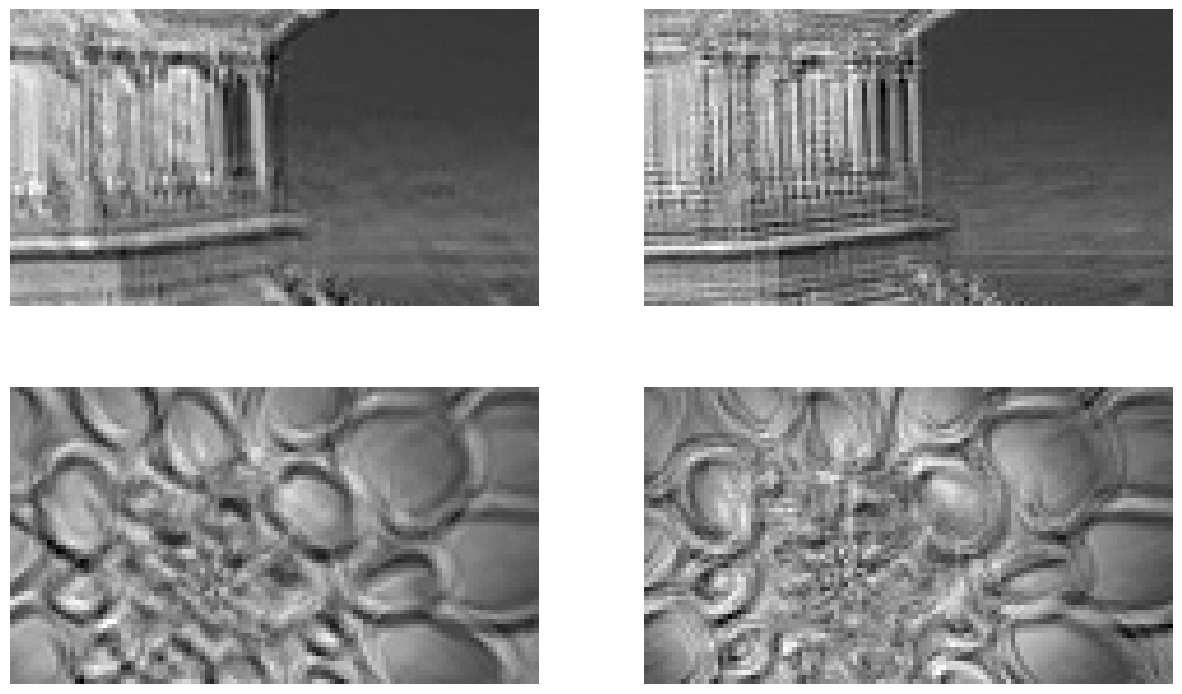

In [5]:
plt.figure(figsize=(15, 9))
for images_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, images_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[images_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

In [6]:
# Now we use zero padding.

conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same")
fmaps = conv_layer(images)
print(fmaps.shape)

(2, 70, 120, 32)


In [7]:
# using strides changes the dimensions.

conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same", strides=2)
fmaps = conv_layer(images)
print(fmaps.shape)

(2, 35, 60, 32)


In [8]:
def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding == "valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size= (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded
    
conv_output_size(np.array([70, 120]), kernel_size=7, strides = 2, padding="same")

(array([35, 60]), array([5, 5]))

In [9]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [10]:
biases.shape

(32,)

In [11]:
tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

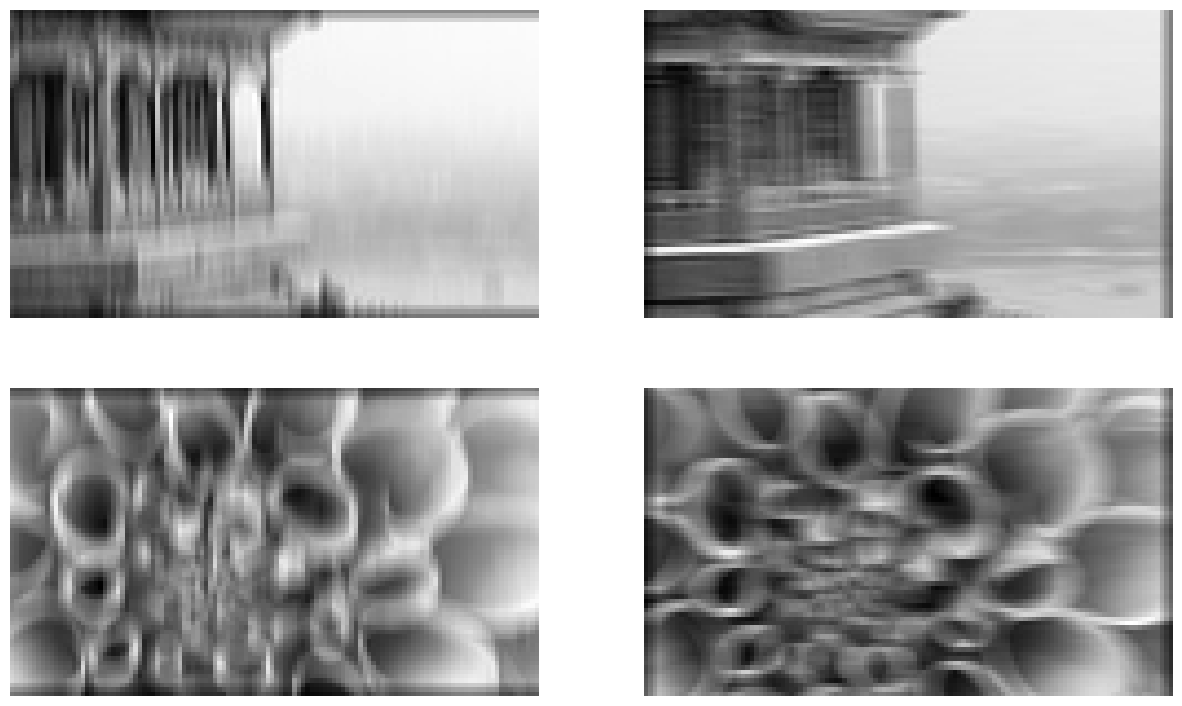

In [12]:
plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0,1):
    for fmap_idx in (0,1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

In [13]:
# Implementing pooling layers with Keras. 

max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [14]:
output = max_pool(images)

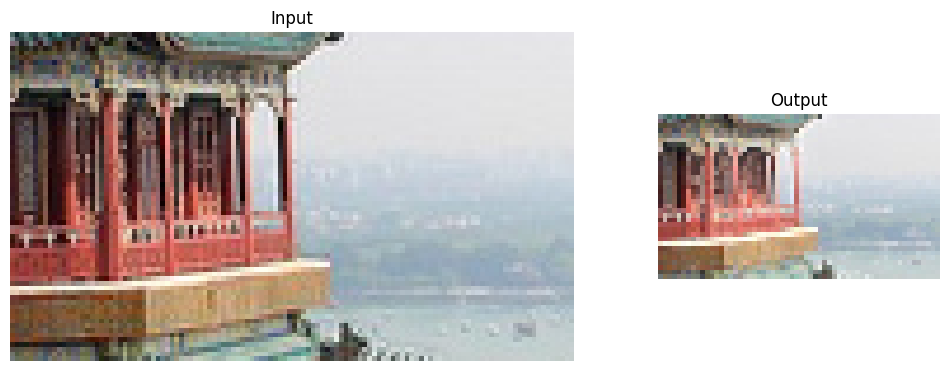

In [15]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])
ax2.axis("off")
plt.show()


In [16]:
np.random.seed(42)
fmaps = np.random.rand(2, 70, 120, 60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3),
                            padding="VALID")
output.shape

TensorShape([2, 70, 120, 20])

In [17]:
# Now we implement depth pooling. 
   
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [18]:
np.allclose(DepthPool(pool_size=3)(fmaps), output)

True

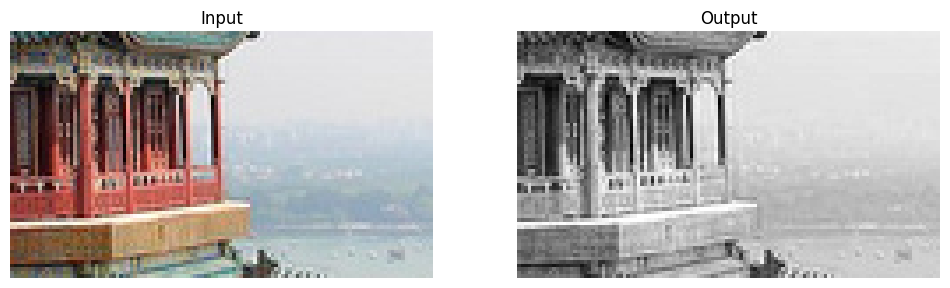

In [19]:
depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(images[0])
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")
plt.axis("off")
plt.show()

In [20]:
# Global Average Pooling 

global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()

In [21]:
global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2])
)
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338624, 0.5971759 , 0.5824972 ],
       [0.76306933, 0.2601113 , 0.10849128]], dtype=float32)>

In [22]:
# Fashion Mnist using a CNN 

mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [25]:
tf.random.set_seed(42)
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same", activation="relu",
                        kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 153s 87ms/step - accuracy: 0.5804 - loss: 1.1724 - val_accuracy: 0.8630 - val_loss: 0.3923
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 172s 100ms/step - accuracy: 0.8367 - loss: 0.4812 - val_accuracy: 0.8858 - val_loss: 0.3119
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 177s 103ms/step - accuracy: 0.8702 - loss: 0.3808 - val_accuracy: 0.8872 - val_loss: 0.2975
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 126s 73ms/step - accuracy: 0.8853 - loss: 0.3360 - val_accuracy: 0.8990 - val_loss: 0.2755
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 130s 76ms/step - accuracy: 0.8999 - loss: 0.2965 - val_accuracy: 0.8904 - val_loss: 0.2915
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 120s 70ms/step - accuracy: 0.9061 - loss: 0.2782 - val_accuracy: 0.9010 - val_loss: 0.2703
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 123s 71ms/step - accuracy: 0.9094 - loss: 0.2684 - val_accuracy: 0.9090 - val_loss: 0.2484
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 139s 81ms/step - accuracy

In [27]:
# Implementing a ResNet-34 Convolutional Neural Network using Keras 

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1, padding="same",
                        kernel_initializer="he_normal", use_bias=False)
    
class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [28]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")
])

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
# Using Pretrained Models from Keras 

model = tf.keras.applications.ResNet50(weights="imagenet")

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


In [30]:
K = tf.keras.backend 
images = K.constant(load_sample_images()["images"])
images_resized = tf.keras.layers.Resizing(height=224, width=224,
                                          crop_to_aspect_ratio=True)(images)

In [31]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

In [32]:
Y_proba = model.predict(inputs)
Y_proba.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(2, 1000)

In [33]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f" {class_id} - {name:12s} {y_proba:.2%}")

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
Image #0
 n03877845 - palace       54.69%
 n03781244 - monastery    24.71%
 n02825657 - bell_cote    18.55%
Image #1
 n04522168 - vase         32.67%
 n11939491 - daisy        17.82%
 n03530642 - honeycomb    12.04%


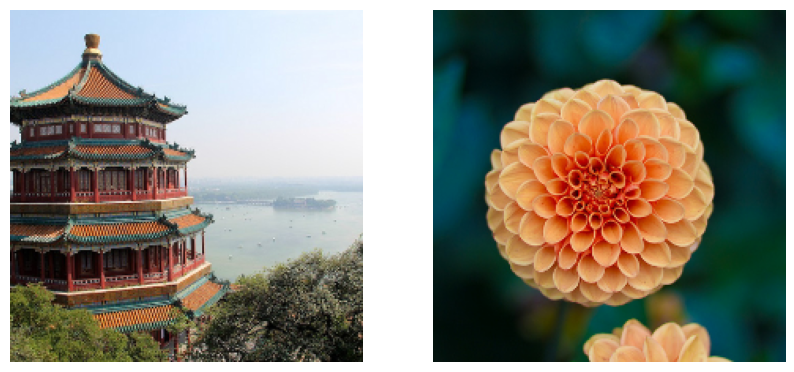

In [34]:
plt.figure(figsize=(10, 6))
for idx in (0, 1):
    plt.subplot(1, 2, idx + 1)
    plt.imshow(images_resized[idx] / 255)
    plt.axis("off")

plt.show()

In [36]:
# Pretrained Models for Transfer Learning 

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples 
class_names = info.features["label"].names 
n_classes = info.features["label"].num_classes

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 100%|██████████| 1/1 [00:35<00:00, 35.38s/ url]
                                                                        

Dataset tf_flowers downloaded and prepared to C:\Users\coryg\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [37]:
dataset_size

3670

In [38]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [39]:
n_classes

5

In [40]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True
)

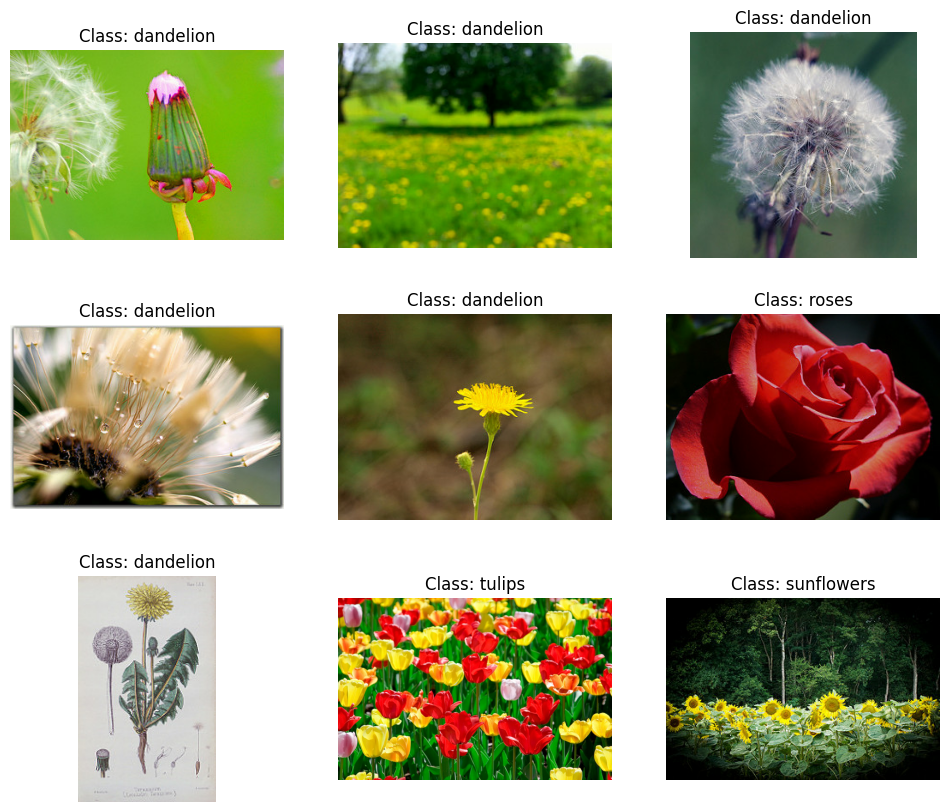

In [41]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

In [42]:
tf.keras.backend.clear_session() 

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

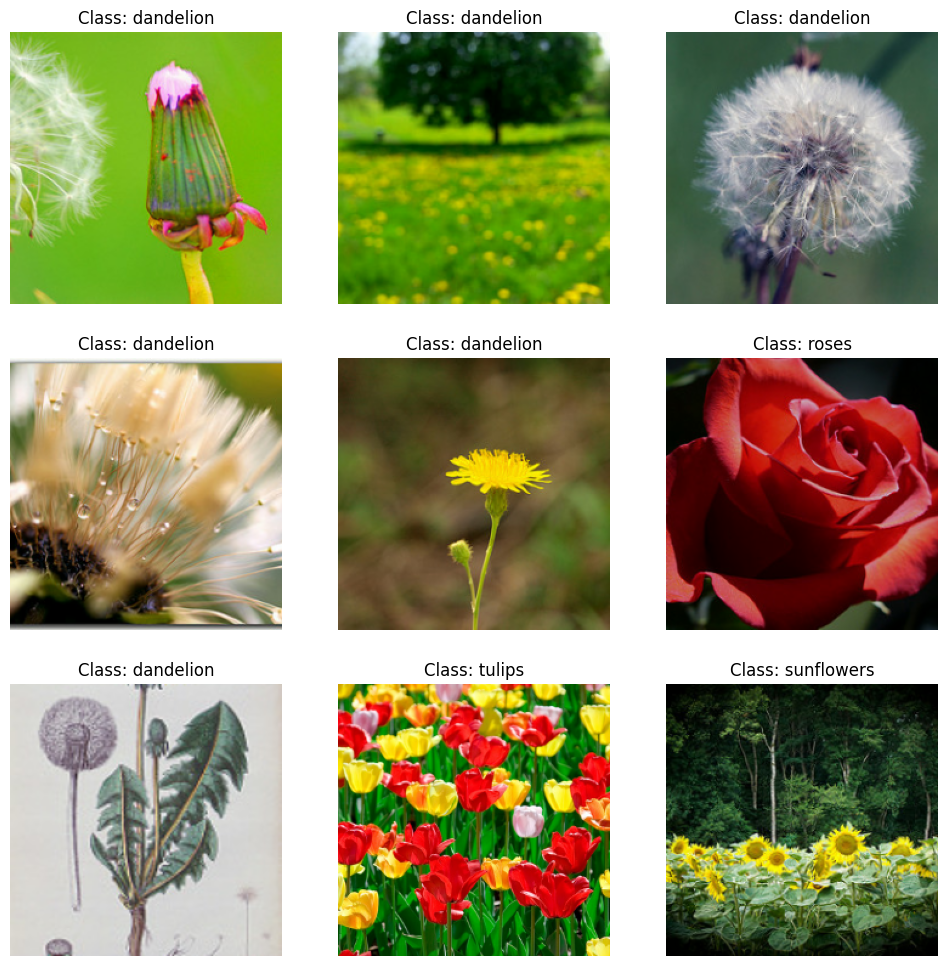

In [43]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [44]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

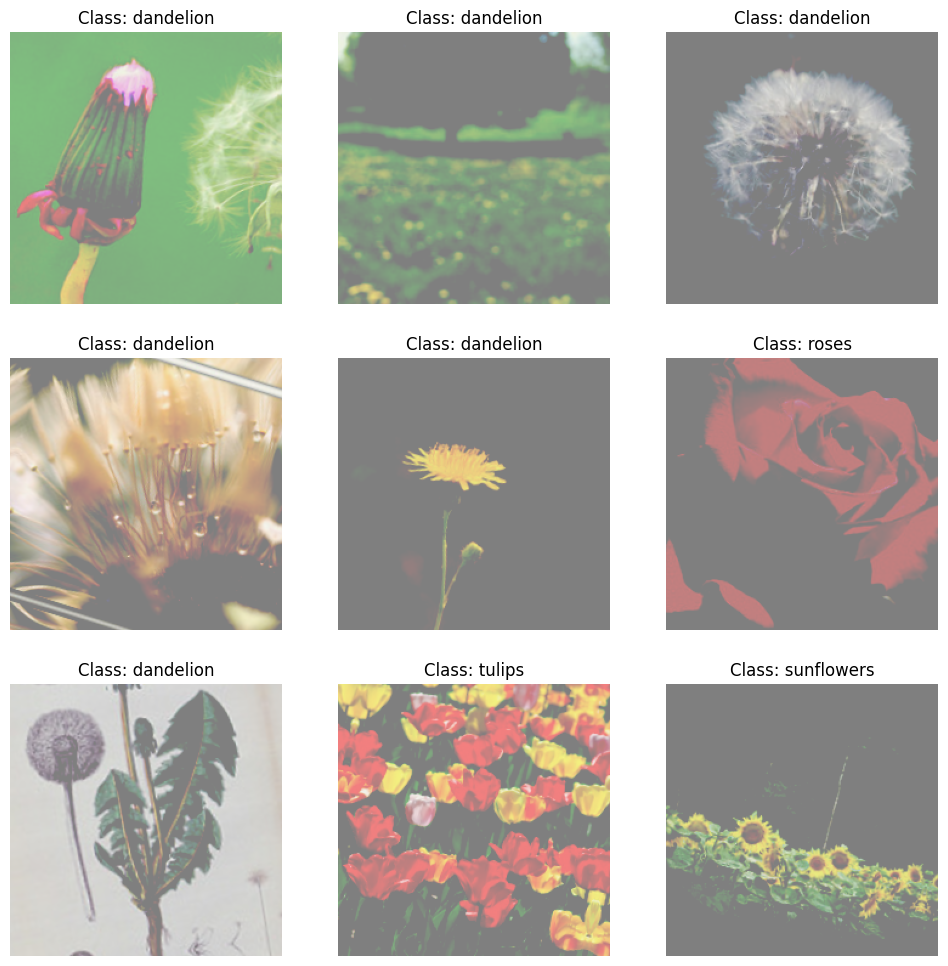

In [45]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [46]:
tf.random.set_seed(42)  
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [47]:
for layer in base_model.layers:
    layer.trainable = False

In [49]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.9148 - loss: 0.3532 - val_accuracy: 0.8530 - val_loss: 0.6109
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.9311 - loss: 0.2272 - val_accuracy: 0.8639 - val_loss: 0.5826
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.9597 - loss: 0.1153 - val_accuracy: 0.8566 - val_loss: 0.6421


In [50]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_layer_2          33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [52]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 355s 4s/step - accuracy: 0.9973 - loss: 0.0075 - val_accuracy: 0.9020 - val_loss: 0.3421
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 382s 4s/step - accuracy: 0.9992 - loss: 0.0034 - val_accuracy: 0.9074 - val_loss: 0.3854
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 340s 4s/step - accuracy: 0.9991 - loss: 0.0032 - val_accuracy: 0.9093 - val_loss: 0.3744


In [53]:
tf.random.set_seed(42)  
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model = tf.keras.Model(inputs=base_model.input,
                       outputs=[class_output, loc_output])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9) 
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], 
              optimizer=optimizer, metrics=["accuracy", "mse"])

In [54]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set, epochs=2)

Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 87s 6s/step - dense_1_accuracy: 0.2379 - dense_1_loss: 1.2878 - dense_2_loss: 0.0895 - dense_2_mse: 0.4475 - loss: 1.3773
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 59s 6s/step - dense_1_accuracy: 0.6396 - dense_1_loss: 0.9191 - dense_2_loss: 0.0398 - dense_2_mse: 0.1991 - loss: 0.9589


In [55]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

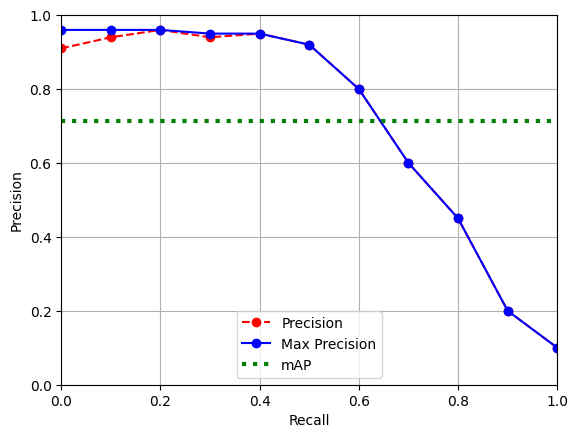

In [56]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center")
plt.show()